In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1

2023-05-04 22:14:36.686662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-05-04 22:14:39.214590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 22:14:39.255422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 22:14:39.255649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
learning_rate = 1e-6
num_dense_layers = 7
num_dense_nodes = 150
iterations = 20000
activation = 'tanh'
weights = 100

In [3]:
nx_train = 100
nx_test = 300

In [4]:
L = 1
m = 1
omega = 0.5
n_max = 2

In [5]:
def pde(x, y):
    n = x[:, 1:2]
    E = (n + 0.5) * omega
    U = 0.5 * m * (omega ** 2) * (x[:, 0:1] ** 2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return -dy_xx / 2 + (U - E) * y

In [6]:
def psi(x):
    n = x[:, 1:2].astype(int)
    factorials = []
    for n_val in n:
        factorials.append(np.math.factorial(int(n_val)))
    factorials = np.array(factorials).reshape(len(factorials), 1)
    
    constants = (1.0 / (np.sqrt(factorials * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)

    exponent = np.exp(-0.5 * m * omega * np.power(x[:, 0:1], 2))
    
    hermite_values = []
    for index, n_val in enumerate(n):
        coefficients = int(n_val) * [0] + [1]
        hermite = np.polynomial.hermite.Hermite(coefficients)
        hermite_value = hermite(x[index, 0] * np.sqrt(m * omega))
        hermite_values.append(hermite_value)
    hermite_values = np.array(hermite_values).reshape(len(hermite_values), 1)

    result = constants * exponent * hermite_values
    return result.astype(dde.config.real(np))

In [7]:
def get_collocation_points(n_max):
    points = []
    for n in range(0, n_max + 1):
        points.append((0.0, n))
    return np.array(points)

In [8]:
def psi_0(x):
    n = int(x[1])
    if n % 2 == 1:
        return 0
        
    normalization_constant = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    if n == 0:
        return normalization_constant
    
    hermite_coefficients = [0] * (n - 2) + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(0)
    
    return -normalization_constant * 2 * (n - 1) * hermite_value

In [9]:
def dpsi_0(x):
    n = int(x[1])
    if n % 2 == 0:
        return 0
    
    normalization_constant = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    constants = 2 * n * np.sqrt(m * omega) * normalization_constant
    
    hermite_coefficients = [0] * (n - 1) + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(0)
    
    return constants * hermite_value

In [10]:
def dpsi_network(x, y, X):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    return dy_x

In [11]:
domain = dde.geometry.Rectangle([-L, 0], [L, n_max])

In [12]:
collocation_points = get_collocation_points(n_max)
collocation_values = np.array([psi_0(x) for x in collocation_points])
collocation_values = collocation_values.reshape(collocation_values.shape + (1,))

derivative_values = np.array([dpsi_0(x) for x in collocation_points])
derivative_values = derivative_values.reshape(derivative_values.shape + (1,))

In [13]:
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)
opic = dde.icbc.PointSetOperatorBC(collocation_points, derivative_values, dpsi_network)

In [14]:
def boundary(x, _):
    if x[1].is_integer():
        return np.isclose(x[0], -L) or np.isclose(x[0], L)
    return False

In [15]:
dirichlet_bc = dde.icbc.DirichletBC(domain, psi, boundary)

In [16]:
bcs = [ic, opic, dirichlet_bc]

In [17]:
data = dde.data.PDE(
    domain, 
    pde, 
    bcs, 
    num_domain=nx_train ** 2, 
    num_boundary=(n_max + 1) * 2,
    solution=psi, 
    num_test=nx_test ** 2
)

In [18]:
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], 
    activation, 
    'Glorot uniform')

In [19]:
model = dde.Model(data, net)

loss_weights = [1, weights, weights, weights]
model.compile(
    'adam', 
    lr=learning_rate, 
    metrics=['l2 relative error'],
    loss_weights=loss_weights
)

Compiling model...
Building feed-forward neural network...


/home/piotr/repos/quant-chem-pinns/venv/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.286769 s



2023-05-04 22:18:38.719003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 22:18:38.719375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 22:18:38.719666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 2.959452 s



In [20]:
loss_history, train_state = model.train(iterations=iterations)

Initializing variables...
Training model...



2023-05-04 22:18:49.345436: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-05-04 22:18:49.580467: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f24a00058f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-04 22:18:49.580499: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-05-04 22:18:49.590924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-04 22:18:50.893874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-04 22:18:55.494576: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                  Test loss                                   Test metric   
0         [7.90e-02, 1.59e+01, 9.63e+00, 8.30e+00]    [7.87e-02, 1.59e+01, 9.63e+00, 8.30e+00]    [1.29e+00]    
1000      [2.92e-02, 1.13e+01, 9.86e+00, 2.67e+00]    [2.91e-02, 1.13e+01, 9.86e+00, 2.67e+00]    [1.02e+00]    
2000      [3.22e-02, 5.63e+00, 9.83e+00, 1.82e+00]    [3.20e-02, 5.63e+00, 9.83e+00, 1.82e+00]    [8.99e-01]    
3000      [4.33e-02, 1.05e+00, 9.51e+00, 1.66e+00]    [4.31e-02, 1.05e+00, 9.51e+00, 1.66e+00]    [7.62e-01]    
4000      [6.53e-02, 1.23e-01, 8.36e+00, 1.24e+00]    [6.50e-02, 1.23e-01, 8.36e+00, 1.24e+00]    [7.17e-01]    
5000      [1.08e-01, 1.18e-01, 4.40e+00, 3.58e-01]    [1.08e-01, 1.18e-01, 4.40e+00, 3.58e-01]    [7.24e-01]    
6000      [1.12e-01, 2.23e-02, 3.67e-01, 1.76e-01]    [1.11e-01, 2.23e-02, 3.67e-01, 1.76e-01]    [7.87e-01]    
7000      [1.44e-01, 1.47e-02, 2.95e-02, 4.54e-02]    [1.44e-01, 1.47e-02, 2.95e-02, 4.54e-02]  

Saving loss history to /home/piotr/repos/quant-chem-pinns/harmonic-oscillator/2d/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/harmonic-oscillator/2d/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/harmonic-oscillator/2d/test.dat ...


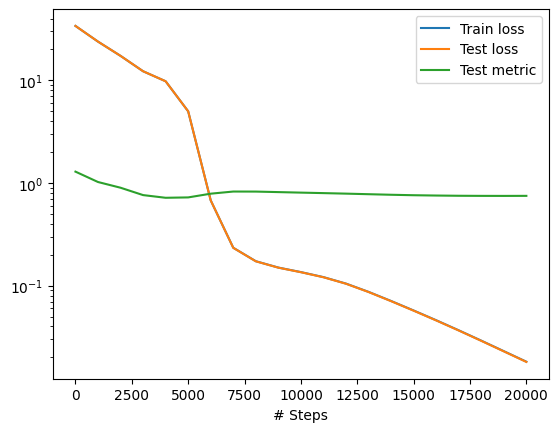

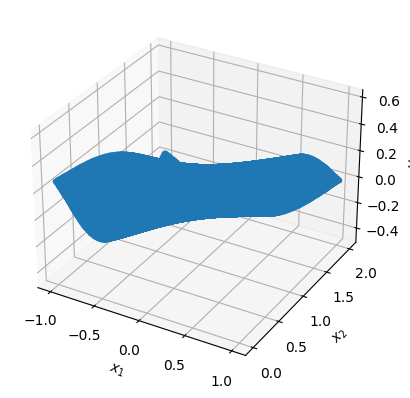

In [21]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [22]:
def predict_for_n(points):
    prediction = model.predict(points)
    return np.array(prediction)

In [23]:
def plot_results_for_n(n, num_points=10):
    x = np.linspace(-L, L, num=num_points)
    points = np.array([[i, n] for i in x])
    predictions = predict_for_n(points)
    true_values = psi(points)
    
    fig, ax = plt.subplots()
    ax.plot(x, predictions, 'bo', label='predicted')
    ax.plot(x, true_values, '--', label='true')
    fig.legend()

In [51]:
def psi_2d_rectangle(x, nx, ny):
    x_values = x[:, 0:1]
    y_values = x[:, 1:2]
    
    x_input = np.array([[i[0], nx] for i in x_values])
    y_input = np.array([[i[0], ny] for i in y_values])
    
    x_component = psi(x_input)
    y_component = psi(y_input)
    
    return x_component * y_component  

In [54]:
def psi_2d_model(x, nx, ny):
    x_values = x[:, 0:1]
    y_values = x[:, 1:2]
    
    x_input = np.array([[i[0], nx] for i in x_values])
    y_input = np.array([[i[0], ny] for i in y_values])
    
    x_component = model.predict(x_input)
    y_component = model.predict(y_input)
    
    return x_component * y_component

In [57]:
def diff_function(x, nx, ny):    
    model_value = psi_2d_model(x, nx, ny)
    true_value = psi_2d_rectangle(x, nx, ny)
    return model_value - true_value

In [58]:
def plot_2d_map(plotted_function, nx, ny, grid_dist=0.01):
    x_ax = np.arange(-L, L, grid_dist)
    y_ax = np.arange(-L, L, grid_dist)
    grid_x, grid_y = np.meshgrid(x_ax, y_ax)
    
    diff_list = []
    for a, b in zip(grid_x, grid_y):
        pair_list = []
        for x, y in zip(a, b):
            pair_list.append([x, y])
        pairs = np.array(pair_list)
        diff_list.append(np.squeeze(plotted_function(pairs, nx, ny)))

    diff_list = np.array(diff_list)
    
    im = plt.imshow(diff_list, cmap=plt.cm.RdBu)
    plt.colorbar(im)

    plt.show()

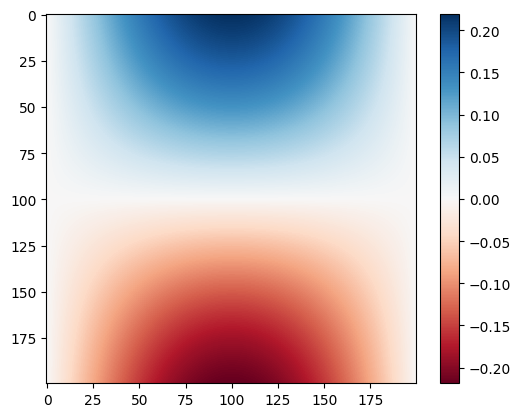

In [55]:
plot_2d_map(psi_2d_rectangle, 2, 1)

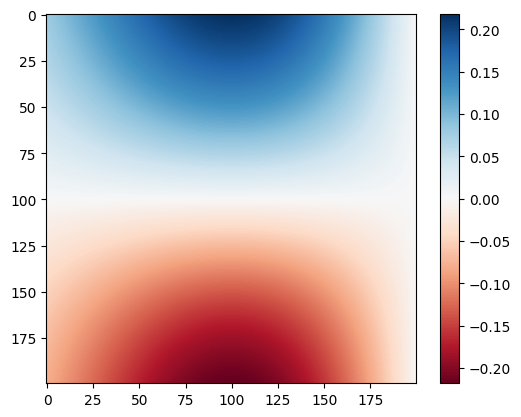

In [56]:
plot_2d_map(psi_2d_model, 2, 1)

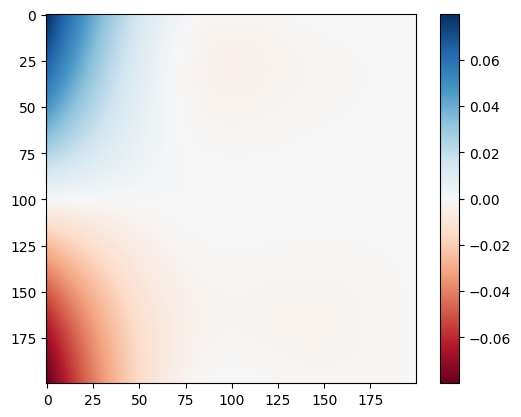

In [59]:
plot_2d_map(diff_function, 2, 1)